In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.io as sci
import os

import torch
import torch.nn as nn
import torch.optim as optim
from random import randrange
from timeit import default_timer as timer


device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [2]:
# Files path
colab = True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/IMA206/Data'
else:
    path = 'Data/'

Mounted at /content/drive


In [3]:
# Load and preprocess images

def load_data(dataset_name):
  Data = {}
  if dataset_name=='Samson':
    Y_file = sci.loadmat(os.path.join(path,'Y_clean.mat'))
    Y = Y_file['Y_clean'].astype(float)

    A_file = sci.loadmat(os.path.join(path,'A_true.mat'))
    A_true = A_file['A_true']

    E_file = sci.loadmat(os.path.join(path,'E.mat'))
    E = E_file['E']

    # Image dimensions
    nCol, nRow = 95, 95
    n, m = 96, 96 # 96-48-24-12
    r_channels = 3
    n_bands = 156

    A_true = np.transpose(A_true, (2,0,1))
    Y = np.transpose(Y, (2,0,1))


  elif dataset_name=='Jasper':

    Y_file = sci.loadmat(os.path.join(path,'jasperRidge2_R198.mat'))
    Y = Y_file['Y'].astype(float)

    gt_file = sci.loadmat(os.path.join(path,'end4.mat'))
    E = gt_file['M']
    A_true = gt_file['A']

    # Image dimensions
    r_channels = 4
    n_bands = 198
    nCol, nRow = 100, 100
    n, m = 112, 112 # 112-56-28-14



  elif dataset_name=='Urban':
    Y_file = sci.loadmat(os.path.join(path,'Urban_R162.mat'))
    Y = Y_file['Y'].astype(float)

    gt_file = sci.loadmat(os.path.join(path,'end6_groundTruth.mat'))
    E = gt_file['M']
    A_true = gt_file['A']

    # Image dimensions
    r_channels = 6
    n_bands = 162
    nCol, nRow = 307, 307
    n, m = 320, 320 # 320-160-80-40


  difference = m-nRow
  # Reflexive padding
  Y_b = np.zeros((n_bands,n,m))
  Y_b[:,:-difference, :-difference] = Y.reshape((n_bands,nCol,nRow))
  Y_b[:,-difference:,:], Y_b[:,:,-difference:] = Y_b[:,:difference,:], Y_b[:,:,:difference]


  A_gt = np.zeros((r_channels, n, m))
  A_gt[:,:-difference, :-difference] = A_true.reshape((r_channels,nCol,nRow))
  A_gt[:,-difference:, :], A_gt[:,:,-difference:] = A_gt[:,:difference,:], A_gt[:,:,:difference]




  # Return the objects in a dictionnary
  Data['r_channels'] = r_channels
  Data['n_bands'] = n_bands
  Data['nRow'] = nRow
  Data['nCol'] = nCol
  Data['image_dimensions'] = n, m
  Data['A_gt'] = torch.tensor(A_gt, dtype=torch.float32).reshape([r_channels,n,m])
  Data['Y'] = torch.tensor(Y_b, dtype=torch.float32).reshape([n_bands,n*m])
  Data['E'] = torch.tensor(E, dtype=torch.float32)
  # Normalize Y
  Data['Y'] = Data['Y']/Data['Y'].max()


  return Data,


# Plot images
def plot_image(A_gt_tensor, E_tensor, Y_tensor, r_channels, n_bands, n, m):
  # Plot abundances
  plt.title('Ground truth abundances')
  plt.figure(figsize=(15,10))
  for i in range(r_channels):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(A_gt_tensor[i,:,:])
  plt.tight_layout()
  plt.show()

  print('Endmembers:')
  plt.plot(E_tensor)
  plt.show()

  rand_bands = randrange(n_bands)
  plt.title(f'Observed image for 6 of {n_bands} bands')
  plt.figure(figsize=(15,10))
  for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow((Y_tensor).reshape(n_bands,n,m)[rand_bands[i],:,:])
  plt.tight_layout()
  plt.show()

  plt.title(f'E@A for 6 of {n_bands} bands (the same bands as above)')
  plt.figure(figsize=(15,10))
  for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(torch.mm(E_tensor,A_gt_tensor.view(r_channels, n*m)).reshape(n_bands,n,m)[rand_bands[i],:,:])
  plt.tight_layout()
  plt.show()

## Helper functions for doing visualizations later, and adding noise to Y tensor

In [4]:
def print_abundance(A_sample):
  for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    im = A_sample.cpu().detach().numpy()
    print(im.shape)
    im = im[0,ii,:,:]
    print(im.shape)
    ax.imshow((im-np.mean(im))/np.std(im))
    plt.show()

In [5]:
def compare_abundances(r_channels, abundances1, abundances2):
  plt.figure(figsize=(12,12))
  for i in range(r_channels):
    ax = plt.subplot(2, r_channels, i+1)
    plt.axis('off')
    if abundances1.shape[1]!=1:
      im = abundances1.cpu().detach().numpy()[i,:,:]
    else:
      im = abundances1.cpu().detach().numpy()[0, i,:,:]
    ax.imshow(im)
    plt.title('Ground truth')

  for i in range(r_channels):
    ax = plt.subplot(2, r_channels, i+1+r_channels)
    plt.axis('off')
    im = abundances2.cpu().detach().numpy()[0,i,:,:]
    ax.imshow(im)
    plt.title('Result')


In [6]:
def compare_abundances_4(r_channels, abundances1, abundances2, abundances3, abundances4):
  plt.figure(figsize=(15,10))
  for i in range(r_channels):
    ax = plt.subplot(4, r_channels, i+1)
    plt.axis('off')
    if abundances1.shape[1]!=1:
      im = abundances1.cpu().detach().numpy()[i,:,:]
    else:
      im = abundances1.cpu().detach().numpy()[0, i,:,:]
    ax.imshow(im)
    plt.title('Ground truth', fontsize = 6)

  for i in range(r_channels):
    ax = plt.subplot(4, r_channels, i+1+r_channels)
    plt.axis('off')
    im = abundances2.cpu().detach().numpy()[0,i,:,:]
    ax.imshow(im)
    plt.title('Result 1', fontsize = 6)

  for i in range(r_channels):
    ax = plt.subplot(4, r_channels, i+1+2*r_channels)
    plt.axis('off')
    im = abundances3.cpu().detach().numpy()[0,i,:,:]
    ax.imshow(im)
    plt.title('Result 2', fontsize = 6)

  for i in range(r_channels):
    ax = plt.subplot(4, r_channels, i+1+3*r_channels)
    plt.axis('off')
    im = abundances4.cpu().detach().numpy()[0,i,:,:]
    ax.imshow(im)
    plt.title('Result 3', fontsize = 6)


In [7]:
def loss_visualization(RMSE, abundance_MAE):

  plt.figure(figsize=(10,2))
  plt.subplot(1,2,1)
  plt.title('Loss function / RMSE')
  plt.plot(RMSE)
  plt.subplot(1,2,2)
  plt.title('abundance MAE')
  plt.plot(abundance_MAE)
  plt.tight_layout()
  plt.show()


In [8]:
def loss_visualization_3(RMSE_1, abundance_MAE_1, RMSE_2, abundance_MAE_2, RMSE_3, abundance_MAE_3):

  plt.figure(figsize=(10,5))
  plt.subplot(3,2,1)
  plt.title('Loss function / RMSE 1')
  plt.plot(RMSE_1)
  plt.subplot(3,2,2)
  plt.title('abundance MAE 1')
  plt.plot(abundance_MAE_1)
  plt.subplot(3,2,3)
  plt.title('Loss function / RMSE 2')
  plt.plot(RMSE_2)
  plt.subplot(3,2,4)
  plt.title('abundance MAE 2')
  plt.plot(abundance_MAE_2)
  plt.subplot(3,2,5)
  plt.title('Loss function / RMSE 3')
  plt.plot(RMSE_3)
  plt.subplot(3,2,6)
  plt.title('abundance MAE 3')
  plt.plot(abundance_MAE_3)
  plt.tight_layout()
  plt.show()

In [9]:
def add_noise(Y_tensor, snr):
  sigma = torch.sqrt(torch.mean(Y_tensor**2)/snr)
  noise = torch.normal(0,sigma,size=Y_tensor.shape, dtype=torch.float32).to(device)
  return Y_tensor + noise

## Definition of the configurable model

In [10]:
# Define the network architecture
class Configurable_Undip_net(nn.Module):
  def __init__(self, r_channels, num_encoder_layers=3, num_decoder_layers=3, limit_pooling=4, skipper_layers=[1,2], num_skip_convolutions=[2,2]):
    super(Configurable_Undip_net, self).__init__()
    encoder_channels = [r_channels,16,32,64,128,256]
    decoder_channels = [256,128,64,32,16,r_channels]

    self.num_encoders = num_encoder_layers
    self.num_decoders = num_decoder_layers
    self.skipper_leyers = skipper_layers


    assert(num_encoder_layers<6), "number of encoder layers should be less than 6"
    assert(num_decoder_layers<6), "number of decoder layers should be less than 6"
    assert(num_encoder_layers==num_decoder_layers), "number of decoder and encoder does not match"
    # contsruct the channel dimensions depending on the 'num_encoder_layers' and 'num_decoder_layers'
    current_encoder_channels = encoder_channels[:num_encoder_layers+1]
    current_decoder_channels = decoder_channels[(5-num_decoder_layers):]

    encoders = nn.ModuleList()
    decoders = nn.ModuleList()
    skips = nn.ModuleList()

    # adding the encoder layers
    for i in range(num_encoder_layers):
      modules = nn.ModuleList()
      modules.extend([nn.Conv2d(current_encoder_channels[i], current_encoder_channels[i+1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                              nn.BatchNorm2d(current_encoder_channels[i+1]),
                              nn.LeakyReLU(inplace=True)]
      )
      if i < limit_pooling:
        modules.append(nn.MaxPool2d(1, stride=2, padding=0))

      encoder = nn.Sequential(*modules)
      encoders.append(encoder)

    # adding the skip connections
    n_skips = 0
    for i in range(num_encoder_layers):
      if i in skipper_layers:
        # meaning there is a skip after the encoder layer i, having current_encoder_channels[i] channels
        n_convs = num_skip_convolutions[n_skips]
        modules = nn.ModuleList()
        for j in range(n_convs):
          modules.extend([nn.Conv2d(current_encoder_channels[i], current_encoder_channels[i], (3, 3), stride=(1, 1), padding=1, dilation=1),
                          nn.BatchNorm2d(current_encoder_channels[i]),
                          nn.LeakyReLU(inplace=True)])

        skip = nn.Sequential(*modules)
        skips.append(skip)
        n_skips += 1


    # creating the base convolution, connecting the two parts of encoder and decoder together
    self.base_conv = nn.Sequential(nn.Conv2d(current_encoder_channels[-1], current_decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                   nn.BatchNorm2d(current_decoder_channels[0]),
                                   nn.LeakyReLU(inplace=True),
    )



    for i in range(num_decoder_layers):
      modules = nn.ModuleList()
      is_skip = num_encoder_layers-i # if num_encoder_layers=4, and the second decoder is i=1, is_skip=3
      if is_skip in skipper_layers:
        if num_decoder_layers-i-1 < limit_pooling:
          modules.append(nn.ConvTranspose2d(encoder_channels[is_skip]+current_decoder_channels[i], current_decoder_channels[i+1], (4, 4), stride=(2, 2), padding=1, dilation=1),)

        else:
          modules.append(nn.Conv2d(encoder_channels[is_skip]+current_decoder_channels[i], current_decoder_channels[i+1], (3, 3), stride=(1, 1), padding=1, dilation=1))
      else:
        if num_decoder_layers-i-1 < limit_pooling:
          modules.append(nn.ConvTranspose2d(current_decoder_channels[i], current_decoder_channels[i+1], (4, 4), stride=(2, 2), padding=1, dilation=1),)

        else:
          modules.append(nn.Conv2d(current_decoder_channels[i], current_decoder_channels[i+1], (3, 3), stride=(1, 1), padding=1, dilation=1))


      modules.append(nn.BatchNorm2d(current_decoder_channels[i+1]))


      if i!=num_decoder_layers-1:
        modules.append(nn.LeakyReLU(inplace=True))
      else:
        modules.append(nn.Softmax())

      decoder = nn.Sequential(*modules)
      decoders.append(decoder)


      self.encoders = encoders
      self.decoders = decoders
      self.skips = skips




  def forward(self, input):


    features = []
    x = input
    for i in range(self.num_encoders):
      x = self.encoders[i](x)
      features.append(x)
      #print('x 0 before base conv ', x.size())




    #print('x 1 before base conv ', x.size())


    x = self.base_conv(x)

    #print('x 2 after base conv ', x.size())


    skip_counter = 0
    for i in range(self.num_decoders):
      skip_num = self.num_decoders - i
      if skip_num in self.skipper_leyers:
        skip_counter += 1
        skip_feats = self.skips[-skip_counter](features[skip_num-1])
        x = torch.cat((skip_feats,x), dim=1)
      # expected 48 channels but got 64
      x = self.decoders[i](x)
      #print('x 3 after ', i, '  decoder  ', x.size())


    output = x

    return output



def train(model, input, r_channels, A_gt_tensor, end_member_estimation, gt_fractional_abundance, epochs=2000, lr=0.01, step_visualize=-1, varying_noise_snr=None):

  losses_train = []
  losses_abundance = []
  RMSE = []
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  end_member_estimation = end_member_estimation.to(device)
  gt_fractional_abundance = gt_fractional_abundance.to(device)
  abundances_tensor = A_gt_tensor.to(device)

  if varying_noise_snr:
    Y_noise = add_noise(gt_fractional_abundance, varying_noise_snr)
  else:
    Y_noise = gt_fractional_abundance

  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()

    optimizer.zero_grad()

    output = model(input)
    #print('the output size ', output.size())
    output = output.to(device)
    #loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    loss = criterion(torch.mm(end_member_estimation, output.view(r_channels, n*m)), Y_noise.to(device))
    rmse = nn.MSELoss()(torch.mm(end_member_estimation, output.view(r_channels, n*m)), gt_fractional_abundance).item()
    abund_loss = nn.L1Loss()(output, abundances_tensor)
    #print('current loss ', loss.item())
    losses_train.append(loss.item())
    losses_abundance.append(abund_loss.item())
    RMSE.append(rmse)

    loss.backward()
    optimizer.step()


    if epoch%step_visualize==0 and step_visualize!=-1:
      print_abundance(output.reshape(-1,r_channels, 320, 320))



  return model, losses_train, losses_abundance, RMSE

In [11]:
def evaluate_model(r_channels, snrs=[None,20,30,40,50], num_encoder_layers=2,
                   num_decoder_layers=2, limit_pooling=4, skipper_layers=[], num_skip_convolutions=[]):


  REs = []
  RMSEs = []
  MAEs = []
  for snr in snrs:
    Undip_model_2_none_none = Configurable_Undip_net(r_channels, num_encoder_layers=num_encoder_layers,
                                                    num_decoder_layers=num_decoder_layers, limit_pooling=limit_pooling,
                                                    skipper_layers=skipper_layers, num_skip_convolutions=num_skip_convolutions)
    _, losses_train, losses_abundance, rmse = train(Undip_model_2_none_none,
                                                    A, r_channels, Data['A_gt'],
                                                    Data['E'], Data['Y'], lr=0.001,
                                                    epochs=1000,varying_noise_snr=snr)
    REs.append(losses_train)
    RMSEs.append(rmse)
    MAEs.append(losses_abundance)




  return REs, RMSEs, MAEs

## Testing different models on Urban data : studying the effect of noise

### what different configurations to try? different number of convolutions, and number of convolutions in the skip connection.

### Models are defined Undip_model_encoder{nencoderchannels}_skip{skip_layers}_skipconvs{skipconvs}

In [12]:
Data = load_data('Urban')
Data = Data[0]
r_channels,n,m = Data['r_channels'], Data['image_dimensions'][0], Data['image_dimensions'][1]
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [13]:
RE_2_none_none, RMSE_2_none_none, MAE_2_none_none = evaluate_model(r_channels,num_encoder_layers=2,
                                                                   num_decoder_layers=2,limit_pooling=4,
                                                                   skipper_layers=[], num_skip_convolutions=[])
RE_2_1_0, RMSE_2_1_0, MAE_2_1_0 = evaluate_model(r_channels, num_encoder_layers=2,
                                                 num_decoder_layers=2, limit_pooling=4,
                                                 skipper_layers=[1], num_skip_convolutions=[0])

RE_2_1_1, RMSE_2_1_1, MAE_2_1_1 = evaluate_model(r_channels, num_encoder_layers=2,
                                                 num_decoder_layers=2, limit_pooling=4,
                                                 skipper_layers=[1], num_skip_convolutions=[1])

# ***************  ***************  ***************. ***************

RE_4_0_0, RMSE_4_0_0, MAE_4_0_0 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[0,0,0])


RE_4_1_1, RMSE_4_1_1, MAE_4_1_1 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[1,1,1])


RE_4_2_2, RMSE_4_2_2, MAE_4_2_2 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[2,2,2])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([6, 320, 320])) that is different to the input size (torch.Size([1, 6, 320, 320])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


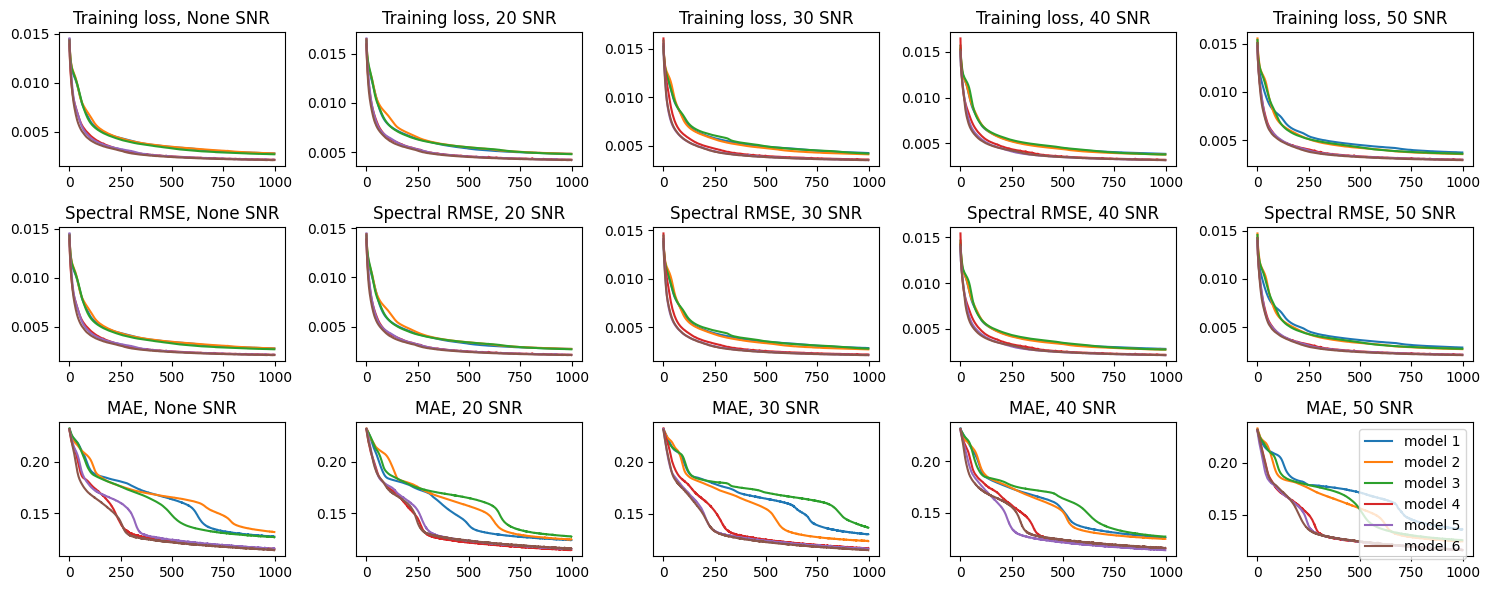

In [14]:
snrs_names=['None','20','30','40','50']
plt.figure(figsize=(15,6))
for i, snr_name in enumerate(snrs_names): # 5 columns (for different values of snr), and 3 rows (for different metrics)
  # different colors for different models

  plt.subplot(3,5,i+1)
  plt.title(f'Training loss, {snr_name} SNR')
  plt.plot(RE_2_none_none[i], label="model 1")
  plt.plot(RE_2_1_0[i], label="model 2")
  plt.plot(RE_2_1_1[i], label="model 3")
  plt.plot(RE_4_0_0[i], label="model 4")
  plt.plot(RE_4_1_1[i], label="model 5")
  plt.plot(RE_4_2_2[i], label="model 6")

  plt.subplot(3,5,5+i+1)
  plt.title(f'Spectral RMSE, {snr_name} SNR')
  plt.plot(RMSE_2_none_none[i], label="model 1")
  plt.plot(RMSE_2_1_0[i], label="model 2")
  plt.plot(RMSE_2_1_1[i], label="model 3")
  plt.plot(RMSE_4_0_0[i], label="model 4")
  plt.plot(RMSE_4_1_1[i], label="model 5")
  plt.plot(RMSE_4_2_2[i], label="model 6")

  plt.subplot(3,5,10+i+1)
  plt.title(f'MAE, {snr_name} SNR')
  plt.plot(MAE_2_none_none[i], label="model 1")
  plt.plot(MAE_2_1_0[i], label="model 2")
  plt.plot(MAE_2_1_1[i], label="model 3")
  plt.plot(MAE_4_0_0[i], label="model 4")
  plt.plot(MAE_4_1_1[i], label="model 5")
  plt.plot(MAE_4_2_2[i], label="model 6")
  plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

## Let us also observe the effect of noise on one of the best models, Undip_model_4_2_2

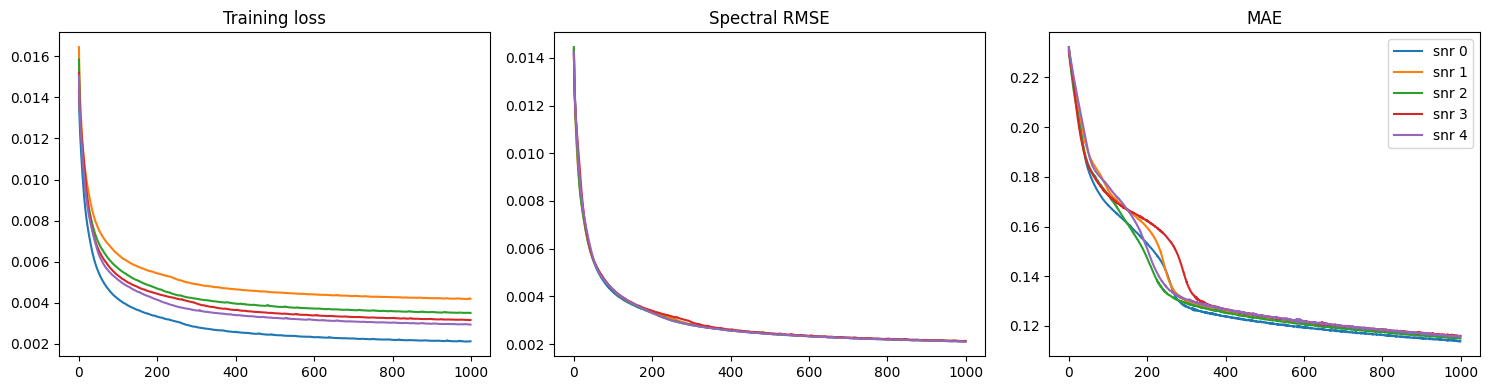

In [15]:
plt.figure(figsize=(15,4))
for i in range(5): # 5 columns (for different values of snr), and 3 rows (for different metrics)
  # different colors for different models

  plt.subplot(1,3,1)
  plt.title(f'Training loss')
  plt.plot(RE_4_2_2[i], label=f"snr {i}")


  plt.subplot(1,3,2)
  plt.title(f'Spectral RMSE')
  plt.plot(RMSE_4_2_2[i], label=f"snr {i}")


  plt.subplot(1,3,3)
  plt.title(f'MAE')
  plt.plot(MAE_4_2_2[i], label=f"snr {i}")


  plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

# Studying the models separately, without any noise on the observation

## Variants of the model with two encoder/decoder layers on Urban

In [16]:
epochs=1000
lr=0.001

In [17]:
Undip_model_2_none_none = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[], num_skip_convolutions=[])
start_train = timer()
Undip_model_2_none_none, losses_train_2_none_none, losses_abundance_2_none_none,_ = train(Undip_model_2_none_none, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_none_none = end_train-start_train
print(f'Training took {time_2_none_none} seconds')


Training took 4.206607701000053 seconds


In [18]:
Undip_model_2_1_0 = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[1], num_skip_convolutions=[0])
start_train = timer()
Undip_model_2_1_0, losses_train_2_1_0, losses_abundance_2_1_0,_ = train(Undip_model_2_1_0, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_1_0 = end_train-start_train
print(f'Training took {time_2_1_0} seconds')


Training took 4.494593362999922 seconds


In [19]:
Undip_model_2_1_1 = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[1], num_skip_convolutions=[1])
start_train = timer()
Undip_model_2_1_1, losses_train_2_1_1, losses_abundance_2_1_1,_ = train(Undip_model_2_1_1, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_1_1 = end_train-start_train
print(f'Training took {time_2_1_1} seconds')


Training took 4.713321833000009 seconds


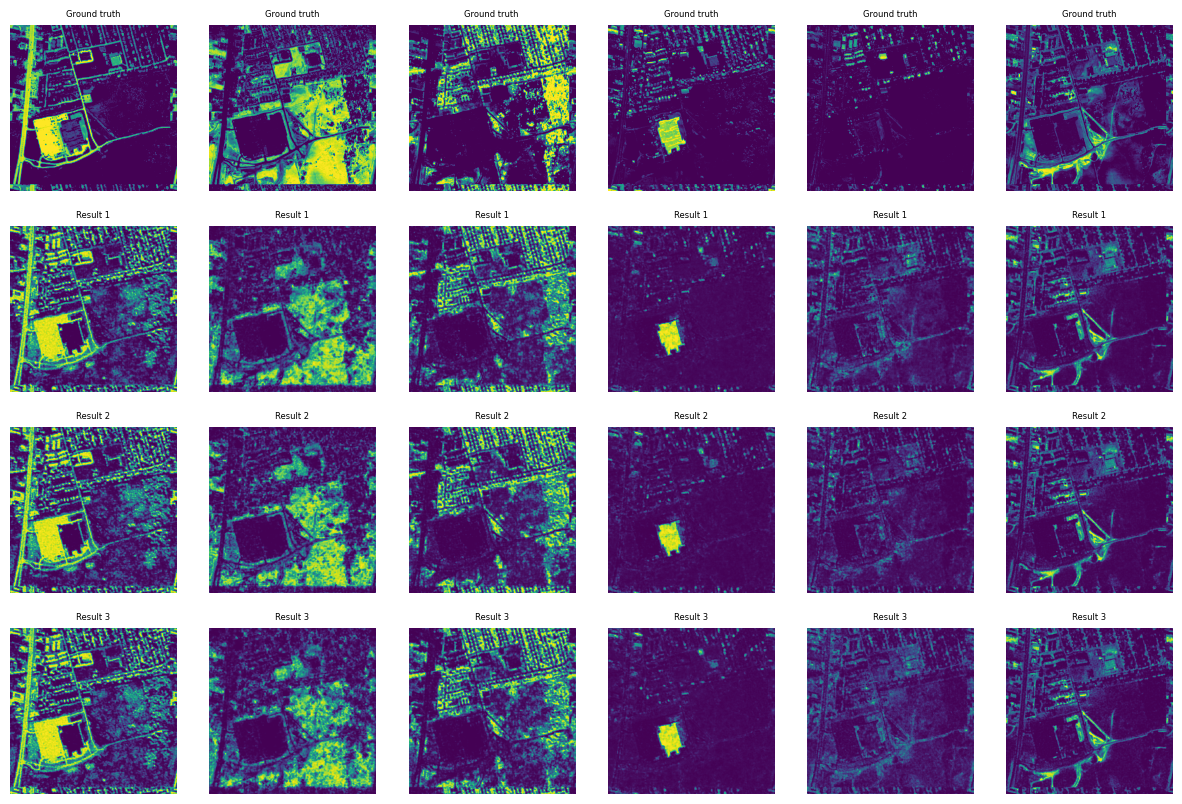

In [20]:
compare_abundances_4(r_channels, Data['A_gt'], Undip_model_2_none_none(A.to(device)), Undip_model_2_1_0(A.to(device)), Undip_model_2_1_1(A.to(device)))

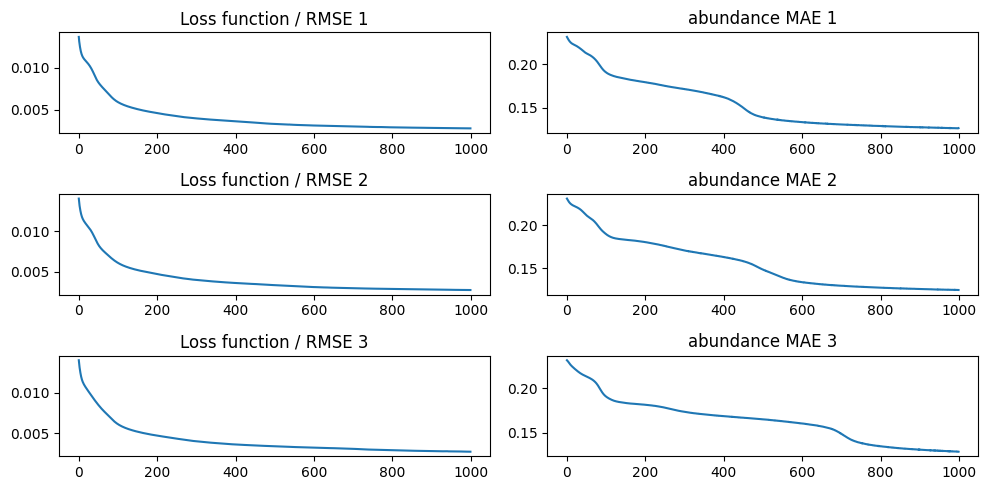

In [21]:
loss_visualization_3(losses_train_2_none_none, losses_abundance_2_none_none, losses_train_2_1_0, losses_abundance_2_1_0, losses_train_2_1_1, losses_abundance_2_1_1)

In [22]:
Undip_model_4_0_0 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[0,0,0])
start_train = timer()
Undip_model_4_0_0, losses_train_4_0_0, losses_abundance_4_0_0,_ = train(Undip_model_4_0_0, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_4_0_0 = end_train-start_train
print(f'Training took {time_4_0_0} seconds')


Training took 6.603672357999926 seconds


In [23]:
Undip_model_4_1_1 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[1,1,1])
start_train = timer()
Undip_model_4_1_1, losses_train_4_1_1, losses_abundance_4_1_1,_ = train(Undip_model_4_1_1, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_4_1_1 = end_train-start_train
print(f'Training took {time_4_1_1} seconds')


Training took 7.653697999999963 seconds


In [24]:
Undip_model_4_2_2 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[2,2,2])
start_train = timer()
Undip_model_4_2_2, losses_train_4_2_2, losses_abundance_4_2_2,_ = train(Undip_model_4_2_2, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_4_2_2 = end_train-start_train
print(f'Training took {time_4_2_2} seconds')


Training took 9.101790789000006 seconds


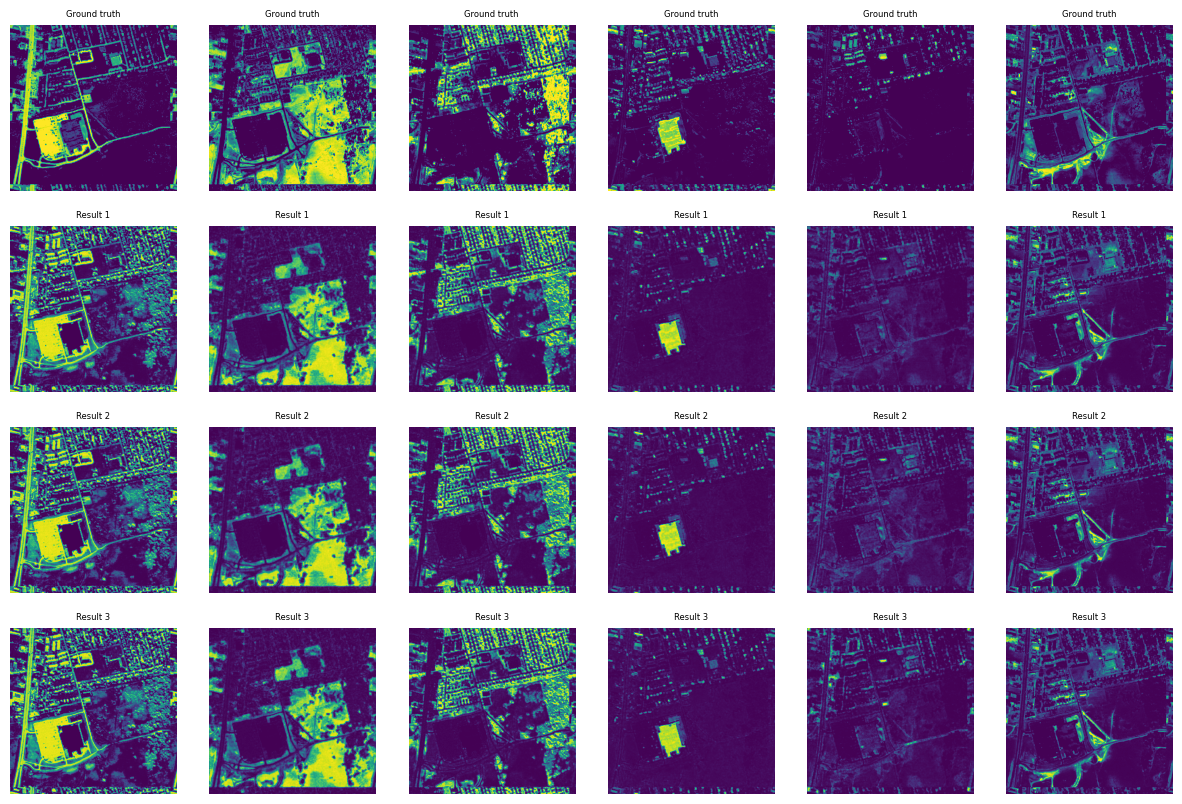

In [25]:
compare_abundances_4(r_channels, Data['A_gt'], Undip_model_4_0_0(A.to(device)), Undip_model_4_1_1(A.to(device)), Undip_model_4_2_2(A.to(device)))

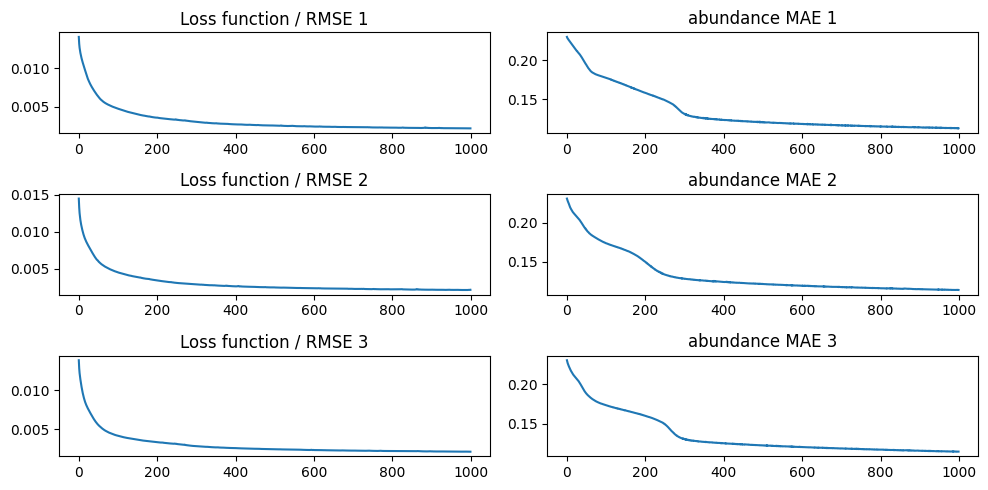

In [26]:
loss_visualization_3(losses_train_4_0_0, losses_abundance_4_0_0, losses_train_4_1_1, losses_abundance_4_1_1, losses_train_4_2_2, losses_abundance_4_2_2)

## Testing different models on Samson data: : studying the effect of noise


In [27]:
Data = load_data('Samson')
Data = Data[0]
r_channels,n,m = Data['r_channels'], Data['image_dimensions'][0], Data['image_dimensions'][1]
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [28]:
RE_2_none_none, RMSE_2_none_none, MAE_2_none_none = evaluate_model(r_channels,num_encoder_layers=2,
                                                                   num_decoder_layers=2,limit_pooling=4,
                                                                   skipper_layers=[], num_skip_convolutions=[])
RE_2_1_0, RMSE_2_1_0, MAE_2_1_0 = evaluate_model(r_channels, num_encoder_layers=2,
                                                 num_decoder_layers=2, limit_pooling=4,
                                                 skipper_layers=[1], num_skip_convolutions=[0])

RE_2_1_1, RMSE_2_1_1, MAE_2_1_1 = evaluate_model(r_channels, num_encoder_layers=2,
                                                 num_decoder_layers=2, limit_pooling=4,
                                                 skipper_layers=[1], num_skip_convolutions=[1])

# ***************  ***************  ***************. ***************

RE_4_0_0, RMSE_4_0_0, MAE_4_0_0 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[0,0,0])


RE_4_1_1, RMSE_4_1_1, MAE_4_1_1 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[1,1,1])


RE_4_2_2, RMSE_4_2_2, MAE_4_2_2 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[2,2,2])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([3, 96, 96])) that is different to the input size (torch.Size([1, 3, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


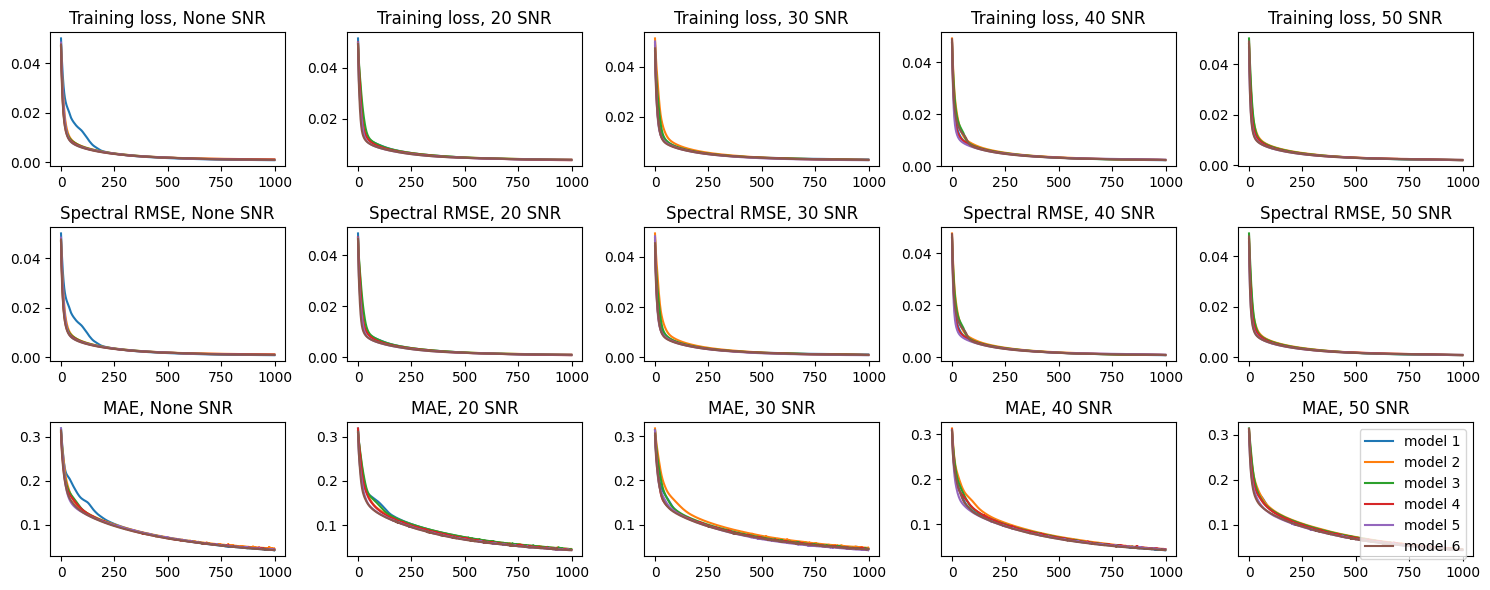

In [29]:
snrs_names=['None','20','30','40','50']
plt.figure(figsize=(15,6))
for i, snr_name in enumerate(snrs_names): # 5 columns (for different values of snr), and 3 rows (for different metrics)
  # different colors for different models

  plt.subplot(3,5,i+1)
  plt.title(f'Training loss, {snr_name} SNR')
  plt.plot(RE_2_none_none[i], label="model 1")
  plt.plot(RE_2_1_0[i], label="model 2")
  plt.plot(RE_2_1_1[i], label="model 3")
  plt.plot(RE_4_0_0[i], label="model 4")
  plt.plot(RE_4_1_1[i], label="model 5")
  plt.plot(RE_4_2_2[i], label="model 6")

  plt.subplot(3,5,5+i+1)
  plt.title(f'Spectral RMSE, {snr_name} SNR')
  plt.plot(RMSE_2_none_none[i], label="model 1")
  plt.plot(RMSE_2_1_0[i], label="model 2")
  plt.plot(RMSE_2_1_1[i], label="model 3")
  plt.plot(RMSE_4_0_0[i], label="model 4")
  plt.plot(RMSE_4_1_1[i], label="model 5")
  plt.plot(RMSE_4_2_2[i], label="model 6")

  plt.subplot(3,5,10+i+1)
  plt.title(f'MAE, {snr_name} SNR')
  plt.plot(MAE_2_none_none[i], label="model 1")
  plt.plot(MAE_2_1_0[i], label="model 2")
  plt.plot(MAE_2_1_1[i], label="model 3")
  plt.plot(MAE_4_0_0[i], label="model 4")
  plt.plot(MAE_4_1_1[i], label="model 5")
  plt.plot(MAE_4_2_2[i], label="model 6")
  plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

## Let us also observe the effect of noise on one of the best models, Undip_model_4_2_2

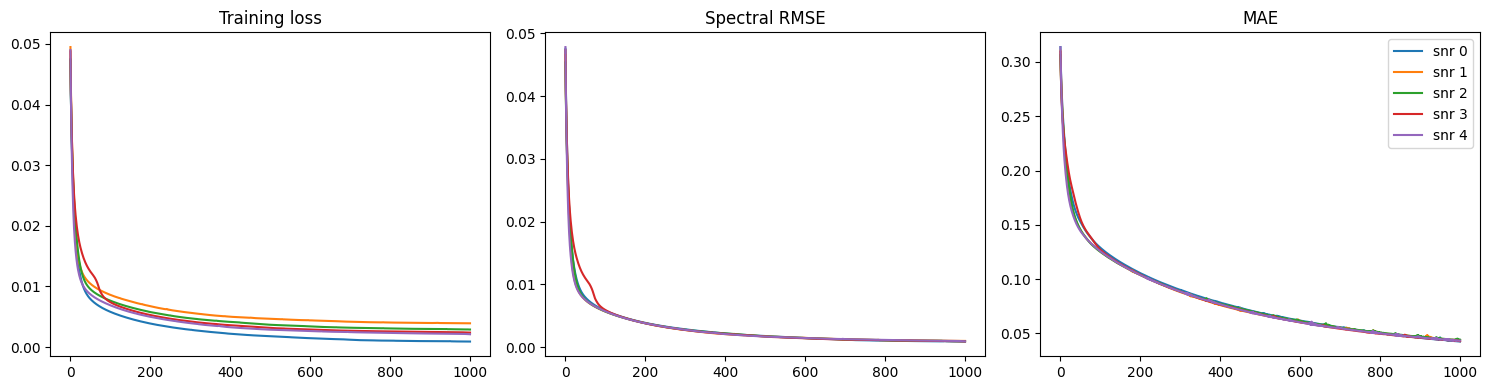

In [30]:
plt.figure(figsize=(15,4))
for i in range(5): # 5 columns (for different values of snr), and 3 rows (for different metrics)
  # different colors for different models

  plt.subplot(1,3,1)
  plt.title(f'Training loss')
  plt.plot(RE_4_2_2[i], label=f"snr {i}")


  plt.subplot(1,3,2)
  plt.title(f'Spectral RMSE')
  plt.plot(RMSE_4_2_2[i], label=f"snr {i}")


  plt.subplot(1,3,3)
  plt.title(f'MAE')
  plt.plot(MAE_4_2_2[i], label=f"snr {i}")


  plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

# Studying the models separately, without any noise on the observation

In [31]:
Undip_model_2_none_none = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[], num_skip_convolutions=[])
start_train = timer()
Undip_model_2_none_none, losses_train_2_none_none, losses_abundance_2_none_none,_ = train(Undip_model_2_none_none, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_none_none = end_train-start_train
print(f'Training took {time_2_none_none} seconds')

Training took 3.7673224400000436 seconds


In [32]:
Undip_model_2_1_0 = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[1], num_skip_convolutions=[0])
start_train = timer()
Undip_model_2_1_0, losses_train_2_1_0, losses_abundance_2_1_0,_ = train(Undip_model_2_1_0, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_1_0 = end_train-start_train
print(f'Training took {time_2_1_0} seconds')


Training took 3.7579169189999675 seconds


In [33]:
Undip_model_2_1_1 = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[1], num_skip_convolutions=[1])
start_train = timer()
Undip_model_2_1_1, losses_train_2_1_1, losses_abundance_2_1_1,_ = train(Undip_model_2_1_1, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_1_1 = end_train-start_train
print(f'Training took {time_2_1_1} seconds')


Training took 4.152300018999995 seconds


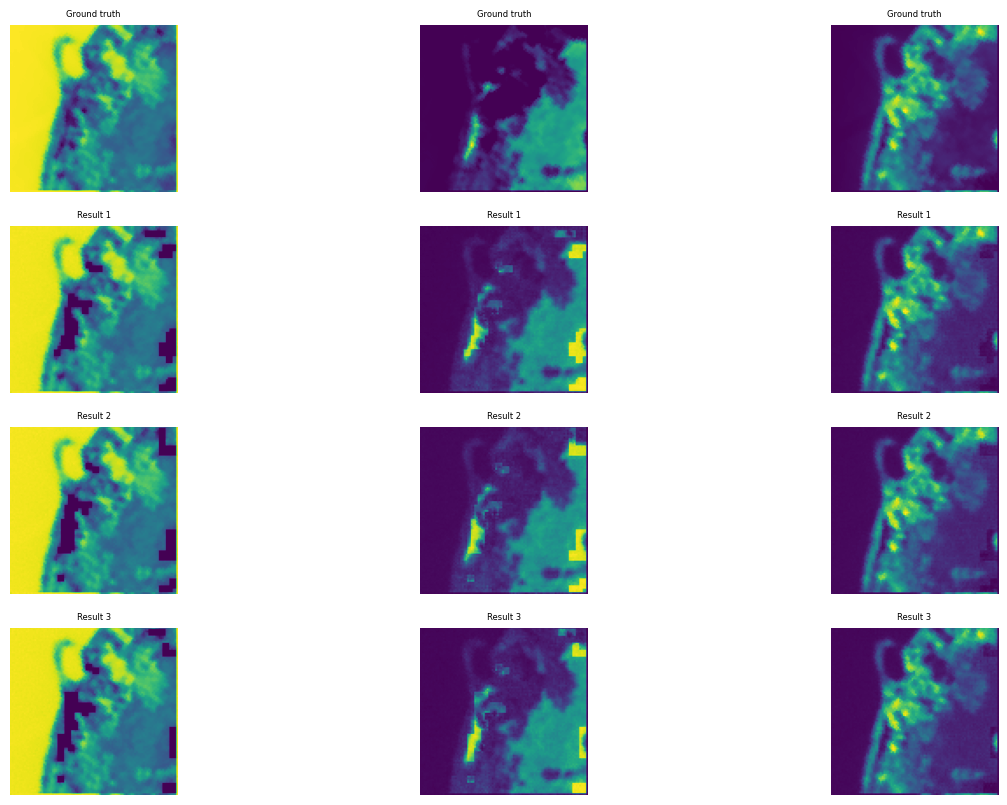

In [34]:
compare_abundances_4(r_channels, Data['A_gt'], Undip_model_2_none_none(A.to(device)), Undip_model_2_1_0(A.to(device)), Undip_model_2_1_1(A.to(device)))

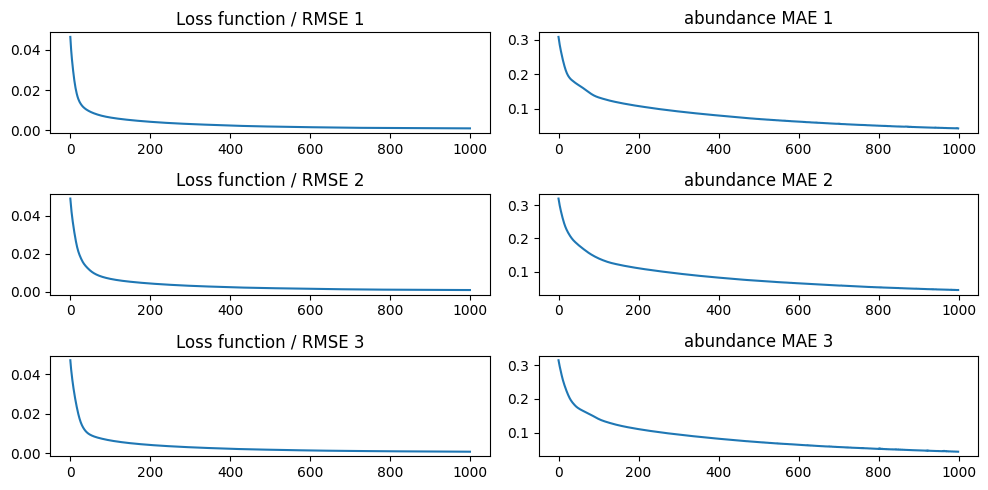

In [35]:
loss_visualization_3(losses_train_2_none_none, losses_abundance_2_none_none, losses_train_2_1_0, losses_abundance_2_1_0, losses_train_2_1_1, losses_abundance_2_1_1)

In [36]:
Undip_model_4_0_0 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[0,0,0])
start_train = timer()
Undip_model_4_0_0, losses_train_4_0_0, losses_abundance_4_0_0,_ = train(Undip_model_4_0_0, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_4_0_0 = end_train-start_train
print(f'Training took {time_4_0_0} seconds')


Training took 6.152570266999987 seconds


In [37]:
Undip_model_4_1_1 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[1,1,1])
start_train = timer()
Undip_model_4_1_1, losses_train_4_1_1, losses_abundance_4_1_1,_ = train(Undip_model_4_1_1, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_4_1_1 = end_train-start_train
print(f'Training took {time_4_1_1} seconds')


Training took 7.376473199999964 seconds


In [38]:
Undip_model_4_2_2 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[2,2,2])
start_train = timer()
Undip_model_4_2_2, losses_train_4_2_2, losses_abundance_4_2_2,_ = train(Undip_model_4_2_2, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_4_2_2 = end_train-start_train
print(f'Training took {time_4_2_2} seconds')


Training took 9.728877488999956 seconds


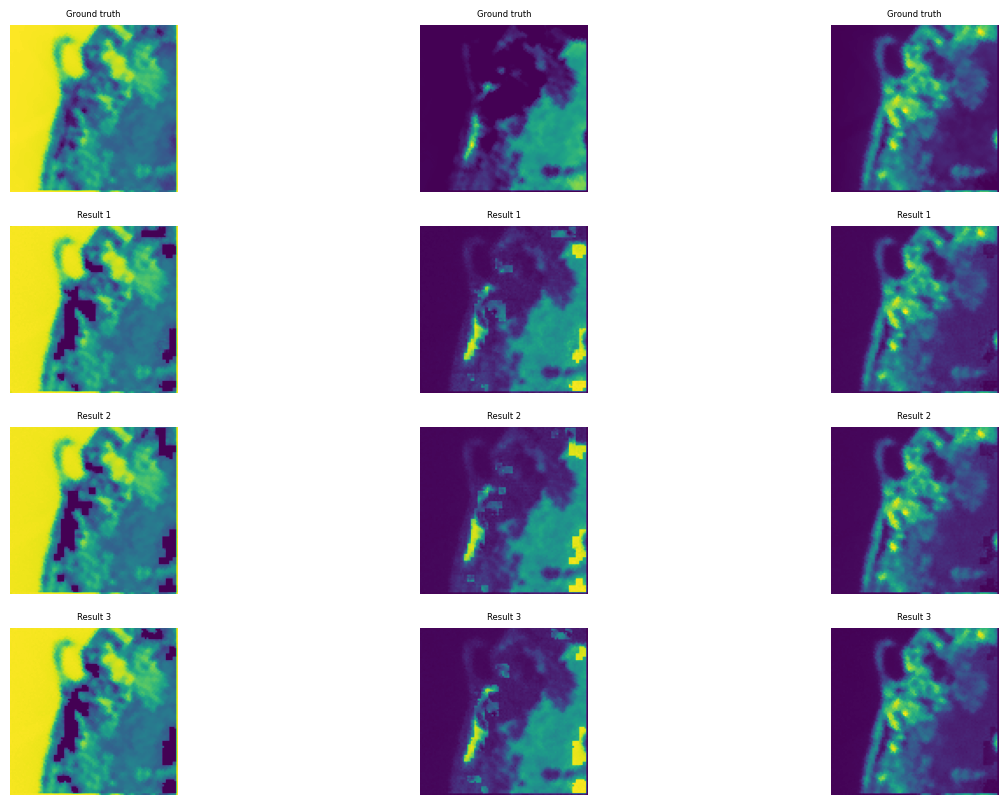

In [39]:
compare_abundances_4(r_channels, Data['A_gt'], Undip_model_4_0_0(A.to(device)), Undip_model_4_1_1(A.to(device)), Undip_model_4_2_2(A.to(device)))

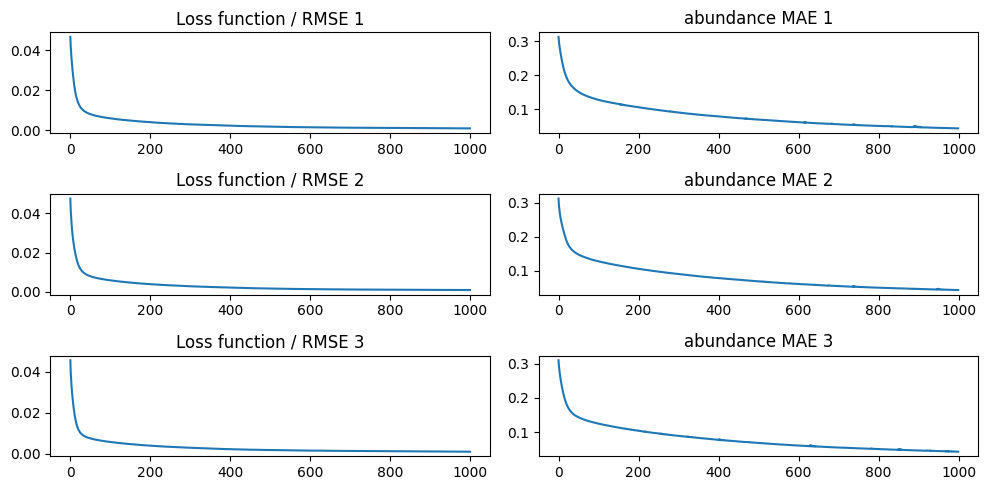

In [40]:
loss_visualization_3(losses_train_4_0_0, losses_abundance_4_0_0, losses_train_4_1_1, losses_abundance_4_1_1, losses_train_4_2_2, losses_abundance_4_2_2)

## Testing different models on Jasper data : Studying the effect of noise

In [41]:
Data = load_data('Jasper')
Data = Data[0]
r_channels,n,m = Data['r_channels'], Data['image_dimensions'][0], Data['image_dimensions'][1]
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [42]:
RE_2_none_none, RMSE_2_none_none, MAE_2_none_none = evaluate_model(r_channels,num_encoder_layers=2,
                                                                   num_decoder_layers=2,limit_pooling=4,
                                                                   skipper_layers=[], num_skip_convolutions=[])
RE_2_1_0, RMSE_2_1_0, MAE_2_1_0 = evaluate_model(r_channels, num_encoder_layers=2,
                                                 num_decoder_layers=2, limit_pooling=4,
                                                 skipper_layers=[1], num_skip_convolutions=[0])

RE_2_1_1, RMSE_2_1_1, MAE_2_1_1 = evaluate_model(r_channels, num_encoder_layers=2,
                                                 num_decoder_layers=2, limit_pooling=4,
                                                 skipper_layers=[1], num_skip_convolutions=[1])

# ***************  ***************  ***************. ***************

RE_4_0_0, RMSE_4_0_0, MAE_4_0_0 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[0,0,0])


RE_4_1_1, RMSE_4_1_1, MAE_4_1_1 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[1,1,1])


RE_4_2_2, RMSE_4_2_2, MAE_4_2_2 = evaluate_model(r_channels, num_encoder_layers=4,
                                                 num_decoder_layers=4, limit_pooling=4,
                                                 skipper_layers=[1,2,3], num_skip_convolutions=[2,2,2])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4, 112, 112])) that is different to the input size (torch.Size([1, 4, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


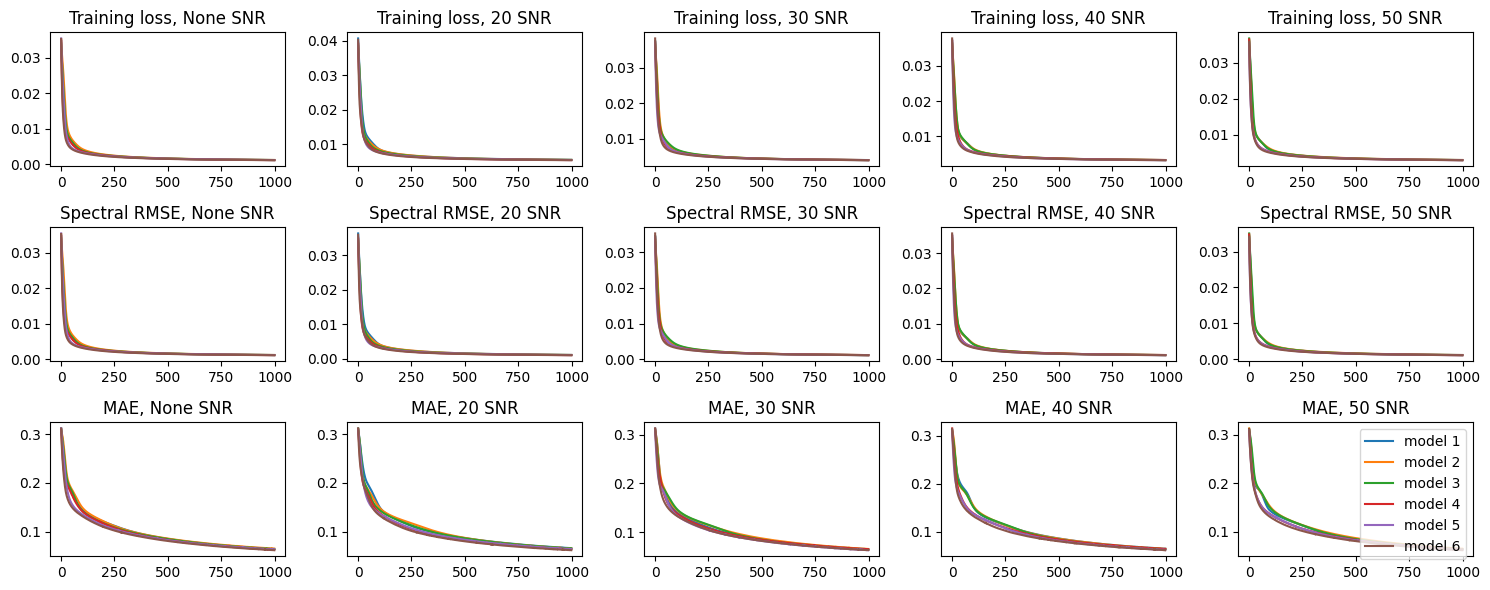

In [43]:
snrs_names=['None','20','30','40','50']
plt.figure(figsize=(15,6))
for i, snr_name in enumerate(snrs_names): # 5 columns (for different values of snr), and 3 rows (for different metrics)
  # different colors for different models

  plt.subplot(3,5,i+1)
  plt.title(f'Training loss, {snr_name} SNR')
  plt.plot(RE_2_none_none[i], label="model 1")
  plt.plot(RE_2_1_0[i], label="model 2")
  plt.plot(RE_2_1_1[i], label="model 3")
  plt.plot(RE_4_0_0[i], label="model 4")
  plt.plot(RE_4_1_1[i], label="model 5")
  plt.plot(RE_4_2_2[i], label="model 6")

  plt.subplot(3,5,5+i+1)
  plt.title(f'Spectral RMSE, {snr_name} SNR')
  plt.plot(RMSE_2_none_none[i], label="model 1")
  plt.plot(RMSE_2_1_0[i], label="model 2")
  plt.plot(RMSE_2_1_1[i], label="model 3")
  plt.plot(RMSE_4_0_0[i], label="model 4")
  plt.plot(RMSE_4_1_1[i], label="model 5")
  plt.plot(RMSE_4_2_2[i], label="model 6")

  plt.subplot(3,5,10+i+1)
  plt.title(f'MAE, {snr_name} SNR')
  plt.plot(MAE_2_none_none[i], label="model 1")
  plt.plot(MAE_2_1_0[i], label="model 2")
  plt.plot(MAE_2_1_1[i], label="model 3")
  plt.plot(MAE_4_0_0[i], label="model 4")
  plt.plot(MAE_4_1_1[i], label="model 5")
  plt.plot(MAE_4_2_2[i], label="model 6")
  plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

## Let us also observe the effect of noise on one of the best models, Undip_model_4_2_2

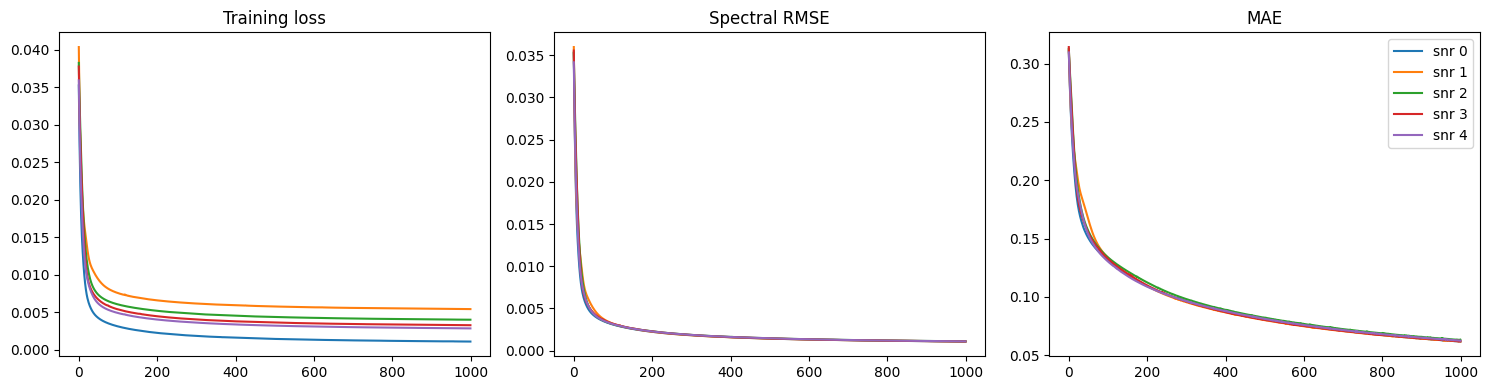

In [44]:
plt.figure(figsize=(15,4))
for i in range(5): # 5 columns (for different values of snr), and 3 rows (for different metrics)
  # different colors for different models

  plt.subplot(1,3,1)
  plt.title(f'Training loss')
  plt.plot(RE_4_2_2[i], label=f"snr {i}")


  plt.subplot(1,3,2)
  plt.title(f'Spectral RMSE')
  plt.plot(RMSE_4_2_2[i], label=f"snr {i}")


  plt.subplot(1,3,3)
  plt.title(f'MAE')
  plt.plot(MAE_4_2_2[i], label=f"snr {i}")


  plt.tight_layout()

plt.legend(loc='upper right')
plt.show()

# Studying the models separately, without any noise on the observation

In [45]:
Undip_model_2_none_none = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[], num_skip_convolutions=[])
start_train = timer()
Undip_model_2_none_none, losses_train_2_none_none, losses_abundance_2_none_none,_ = train(Undip_model_2_none_none, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_none_none = end_train-start_train
print(f'Training took {time_2_none_none} seconds')

Training took 3.946777427000029 seconds


In [46]:
Undip_model_2_1_0 = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[1], num_skip_convolutions=[0])
start_train = timer()
Undip_model_2_1_0, losses_train_2_1_0, losses_abundance_2_1_0,_ = train(Undip_model_2_1_0, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_1_0 = end_train-start_train
print(f'Training took {time_2_1_0} seconds')


Training took 3.7596181849999084 seconds


In [47]:
Undip_model_2_1_1 = Configurable_Undip_net(r_channels, num_encoder_layers=2, num_decoder_layers=2, limit_pooling=4, skipper_layers=[1], num_skip_convolutions=[1])
start_train = timer()
Undip_model_2_1_1, losses_train_2_1_1, losses_abundance_2_1_1,_ = train(Undip_model_2_1_1, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=lr, epochs=epochs)
end_train = timer()
time_2_1_1 = end_train-start_train
print(f'Training took {time_2_1_1} seconds')


Training took 4.177160862000051 seconds


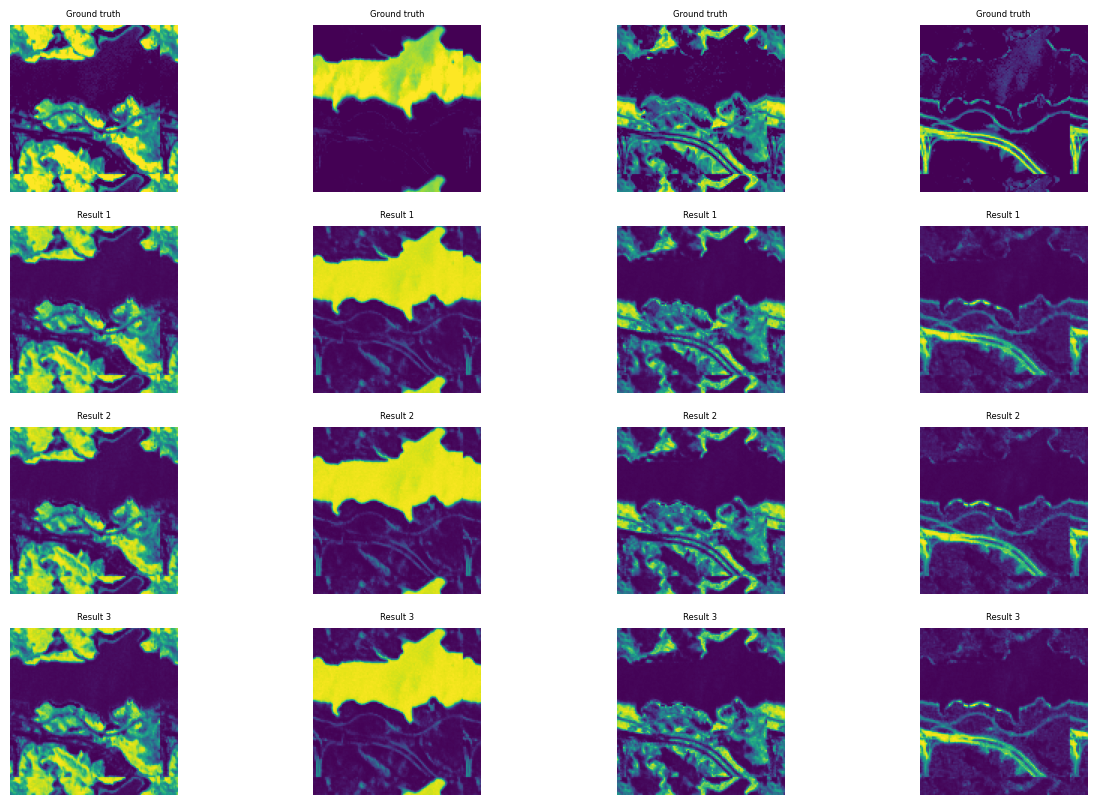

In [48]:
compare_abundances_4(r_channels, Data['A_gt'], Undip_model_2_none_none(A.to(device)), Undip_model_2_1_0(A.to(device)), Undip_model_2_1_1(A.to(device)))

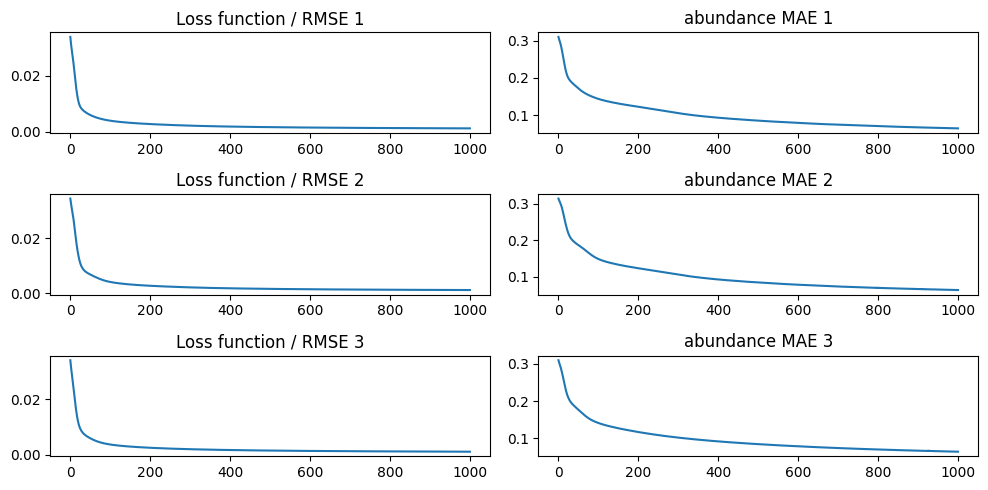

In [49]:
loss_visualization_3(losses_train_2_none_none, losses_abundance_2_none_none, losses_train_2_1_0, losses_abundance_2_1_0, losses_train_2_1_1, losses_abundance_2_1_1)

In [50]:
Undip_model_4_0_0 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[0,0,0])
start_train = timer()
Undip_model_4_0_0, losses_train_4_0_0, losses_abundance_4_0_0,_ = train(Undip_model_4_0_0, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=0.001, epochs=500)
end_train = timer()
time_4_0_0 = end_train-start_train
print(f'Training took {time_4_0_0} seconds')


Training took 3.091117156999985 seconds


In [51]:
Undip_model_4_1_1 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[1,1,1])
start_train = timer()
Undip_model_4_1_1, losses_train_4_1_1, losses_abundance_4_1_1,_ = train(Undip_model_4_1_1, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=0.001, epochs=500)
end_train = timer()
time_4_1_1 = end_train-start_train
print(f'Training took {time_4_1_1} seconds')


Training took 3.687469942000007 seconds


In [52]:
Undip_model_4_2_2 = Configurable_Undip_net(r_channels, num_encoder_layers=4, num_decoder_layers=4, limit_pooling=4, skipper_layers=[1,2,3], num_skip_convolutions=[2,2,2])
start_train = timer()
Undip_model_4_2_2, losses_train_4_2_2, losses_abundance_4_2_2,_ = train(Undip_model_4_2_2, A, r_channels, Data['A_gt'], Data['E'], Data['Y'], lr=0.001, epochs=500)
end_train = timer()
time_4_2_2 = end_train-start_train
print(f'Training took {time_4_2_2} seconds')


Training took 4.298691254000005 seconds


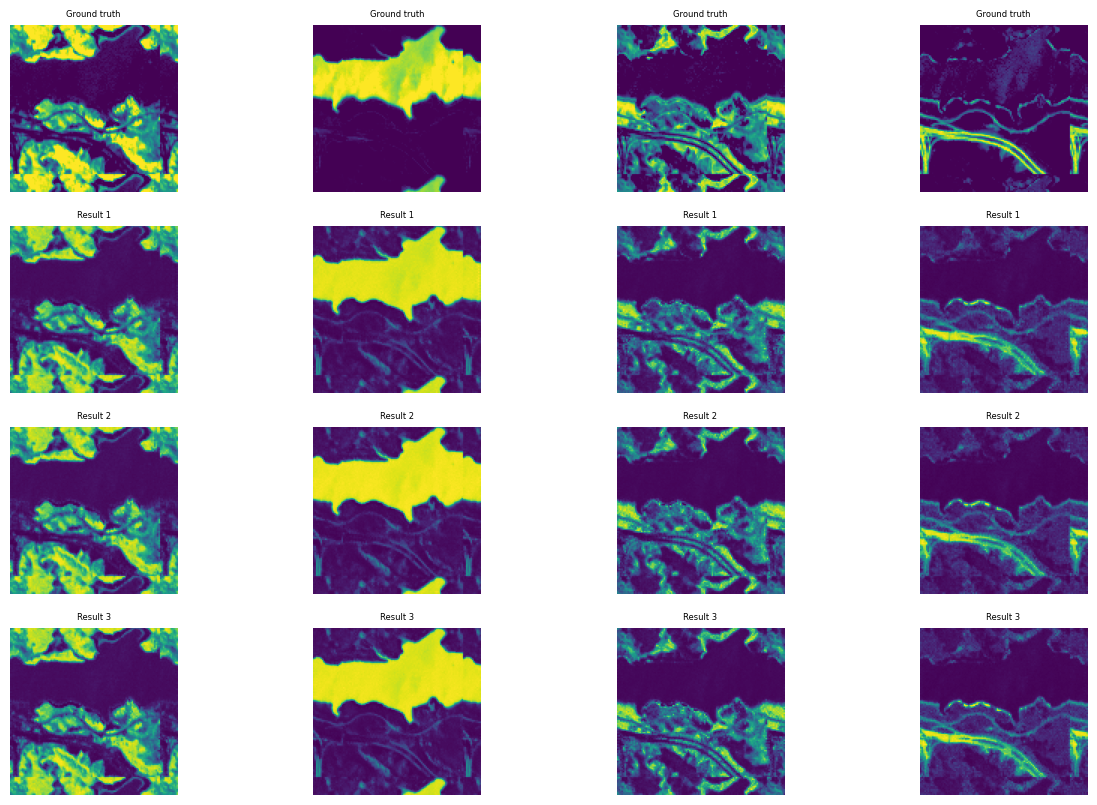

In [53]:
compare_abundances_4(r_channels, Data['A_gt'], Undip_model_4_0_0(A.to(device)), Undip_model_4_1_1(A.to(device)), Undip_model_4_2_2(A.to(device)))

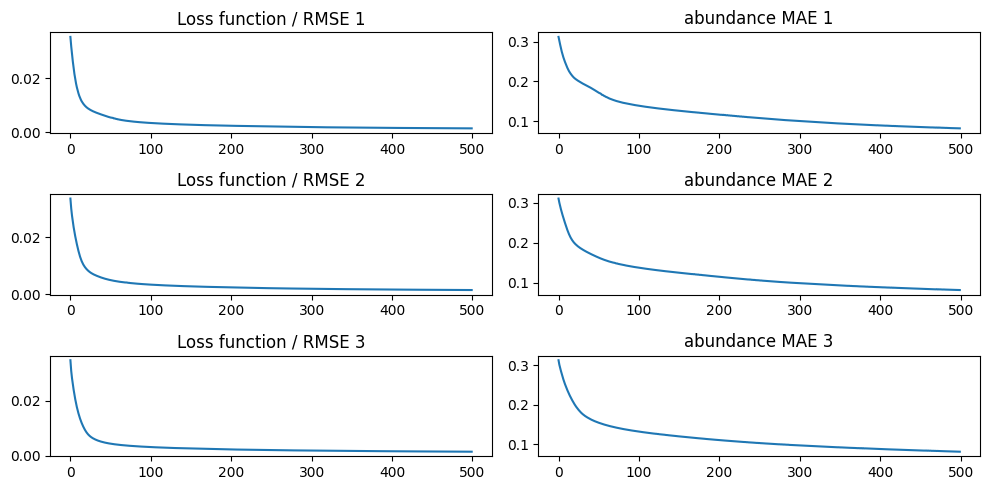

In [54]:
loss_visualization_3(losses_train_4_0_0, losses_abundance_4_0_0, losses_train_4_1_1, losses_abundance_4_1_1, losses_train_4_2_2, losses_abundance_4_2_2)

## Usage of some other function to see the results closer!!

In [55]:
loss_visualization(losses_train, losses_abundance)

NameError: ignored

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

compare_abundances(r_channels, Data['A_gt'], model(A.to(device)))